# Task 1: Data Preprocessing and Analysis


In [3]:
# packages
import os
import re
import numpy as np
import pandas as pd
import json
import string
#%pip install bs4

from bs4 import BeautifulSoup
import jieba
import jieba.analyse
from zhconv import convert 
from opencc import OpenCC
import transformers
import sklearn
import torch
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 


from sklearn.feature_extraction.text import TfidfVectorizer
from torch.nn.functional import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import joblib
from transformers import BertTokenizer, AutoModel
import torch.nn.functional as F
from tqdm import tqdm


from scipy.sparse import csr_matrix



c:\Users\cindy\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Question 1: Data Preprocessing - Noise Removal

Report requirements

(a) Present the noise removal strategies you ’ve tried and analyze the results. Please provide as much detail as possible about your strategy, including equations, images, and so on.

(b) Introduce the filter rates of each strateg y , i.e.,
𝑓𝑖𝑙𝑡𝑒𝑟 rate = filtered news / Total news

## 1(a) approaches for noise removal

To remove noises of unrelated news, we use similarity-based method and do exact-matching as comparison / baseline. 

We will first preview the provided documnets: News and A_share_list.

### 0. load data + preview

In [ ]:
# Load data
news_data = pd.read_excel('data/News.xlsx')

with open("A_share_list.json", "r", encoding="utf-8") as file:
    a_share_list = json.load(file)

In [25]:
news_data.shape

(1037035, 4)

In [ ]:
news_data.head()

,NewsID,Title,NewsContent,NewsSource
0,1,建设银行原董事长张恩照一审被判15年,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,中国证券报
1,2,农行信用卡中心搬到上海滩,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,人民日报
2,3,外运发展：价值型蓝筹股补涨要求强烈,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,杭州新希望
3,4,胜利股份：稳步走强形成标准上升通道,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,源达投资
4,5,[港股快讯]恒指收市报18960点 成交467亿港元,全景网11月30日讯 外围股市造好，带动港股今早造好，恒指高开后反覆上升，最高升252点...,全景网


In [10]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037035 entries, 0 to 1037034
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   NewsID       1037035 non-null  int64 
 1   Title        1037035 non-null  object
 2   NewsContent  1036614 non-null  object
 3   NewsSource   1022262 non-null  object
dtypes: int64(1), object(3)
memory usage: 31.6+ MB


In [13]:
print(a_share_list[:1])

[{'name': '邵阳液压', 'fullname': '邵阳维克液压股份有限公司', 'code': '301079', 'location': '深圳证券交易所', 'time': '2021-10-19'}]


### 1. exact match
We match the name, full name and code to see if any of them match exactly with the news title or in news content. 

In [ ]:
def_data = news_data.copy()

def extract_explicit_companies(news_text, a_share_companies):
    explicit_companies = []
    for company in a_share_companies:
        if check_exact_matches(news_text, [company]):
            explicit_companies.append(company["name"])
    return ','.join(explicit_companies)

def check_exact_matches(news_text, a_share_companies):
    for company in a_share_companies:
        if company["name"] in news_text or company["fullname"] in news_text or company["code"] in news_text:
            return True  # Match found
    return False  # No match found

# Apply the check_matches function to the Title and NewsContent columns
def_data['Match'] = def_data.apply(lambda row: check_exact_matches(str(row['Title']) + ' ' + str(row['NewsContent']), a_share_list), axis=1)
def_data['Explicit_Company'] = def_data['NewsContent'].apply(lambda x: extract_explicit_companies(str(x), a_share_list))

#checkpoint
def_data.to_csv('others/checkpoints/def_data.csv', index=False)

# Filter out rows where there is a match fir filter rate
def_match_data = def_data[def_data['Match']==1]

In [28]:
#def_data = pd.read_csv('others/checkpoints/def_data.csv')
def check_exact_matches(news_text, a_share_companies):
    for company in a_share_companies:
        if company["name"] in news_text or company["fullname"] in news_text or company["code"] in news_text:
            return True  # Match found
    return False  # No match found

def extract_explicit_companies(news_text, a_share_companies):
    explicit_companies = []
    for company in a_share_companies:
        if check_exact_matches(news_text, [company]):
            explicit_companies.append(company["name"])
    return ','.join(explicit_companies)
def_data['Explicit_Company'] = def_data['NewsContent'].apply(lambda x: extract_explicit_companies(str(x), a_share_list))


In [31]:
def_data.head()
def_data.to_csv('others/checkpoints/def_data.csv', index=False)

### 2. similarity based - TFIDF (discarded apporach)
To find the words similar to the suggested stock in list, We tried using TFIDF vectoriser for text mining based on the frequency of terms. We once considered it as a benchmark though it has limited contextual understanding, but kater discarded due to dispersed representation, insufficient contextual understanding and runtime issues.
### ** this part includes data preprocessing **


We will first preprocess the data for vectorisation, with reference to the plentiful resources that Github contributors have provided, such as using stopwords.txt provided by jieba.(its respective functions are not used due to error)

In [7]:
#%pip install jieba
#%pip install opencc
#%pip install sentence_transformers
#%pip install opencc-python-reimplemented
#pip install zhconv
# 1. remove punctuations
def remove_punctuation(text):
    if isinstance(text, str):
        # Remove punctuation using re.sub
        line = re.sub("[！？。｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃《》「」『』&#8203;``【oaicite:0】``&#8203;〔〕\
                    〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+", "", text) 
        return line
    else:
        return text


# 2. remove stop words
def remove_stop_words(text, stop_word_path='others/materials/stop_words.txt'):
    # Check if the text is a string, handle NaN or missing values
    if isinstance(text, str):
        # Open the stop words file in read mode
        with open(stop_word_path, 'r', encoding='utf-8') as stop_word_file:
            # Read the stop words from the file and create a set
            stop_word = set(stop_word_file.read().split())

        # Use jieba.cut to tokenize the text
        words = jieba.cut(text, cut_all=False)

        # Filter out stop words using the stop words set
        filtered_words = [word for word in words if word not in stop_word]

        # Join the filtered words into a string
        return ' '.join(filtered_words)
    else:
        # Return an empty string or handle as per your requirement for non-string values
        return ''

#3 
import re
def exclude_urls(text):
    if isinstance(text, str):
        # Use regular expression to remove URLs
        text_without_urls = re.sub(r'http\S+|https\S+', '', text)
        return text_without_urls
    else:
        return text


#4 
def convert_to_simplified(text):
    # Check if the text is not NaN
    if pd.notna(text):
        # Function to convert a text to simplified Chinese using zhconv
        simplified_text = convert(text, 'zh-hans')
        return simplified_text
    else:
        return text


In [23]:
# combine the news title and content, and apply the function to df
def_data = pd.read_csv('others/checkpoints/def_data.csv')
tfidf_data = def_data.copy()
tfidf_data['title_content'] = tfidf_data['Title'] + ' ' + tfidf_data['NewsContent']
tfidf_data['title_content'] = tfidf_data['title_content'].apply(remove_punctuation)
tfidf_data['title_content'] = tfidf_data['title_content'].apply(remove_stop_words)
tfidf_data['title_content'] = tfidf_data['title_content'].apply(exclude_urls)
tfidf_data['title_content'] = tfidf_data['title_content'].apply(convert_to_simplified)

# Sort the DataFrame by the 'Match' column in descending order
tfidf_data_sorted = tfidf_data.sort_values(by='Match', ascending=False)
tfidf_data_sorted.to_csv('others/checkpoints/tfidf_data_sorted.csv', index=False)

# Get titleand news content of exact and non-exact matches
exact_matches = tfidf_data_sorted[tfidf_data_sorted['Match'] == 1]['title_content'].tolist()
non_exact_matches = tfidf_data_sorted[tfidf_data_sorted['Match'] == 0]['title_content'].tolist()

# Concatenate the lists
all_tfidf_text = exact_matches + non_exact_matches

The tfidf vectoriser has set to have the following parameters. After that, we desribe the statistics of the cosine similarities and select a threshold for filtering.

In [ ]:
# use tfidf vectoriser 
tfidf_vectorizer = TfidfVectorizer(
    max_features=100000,  
    stop_words=None,  # already processed
    ngram_range=(1, 2),  # Adjust the n-gram range
    decode_error = 'ignore',
    max_df = 0.7, # ignore frequent occuring words
    min_df = [0.0]
)
# fit
tfidf_matrix = tfidf_vectorizer.fit_transform(non_exact_matches)

# Save the vectorizer
joblib.dump(tfidf_vectorizer, 'others/checkpoints/tfidf_vectorizer.pkl')
joblib.dump(tfidf_matrix, 'others/checkpoints/tfidf_matrix.pkl')

In [ ]:
# loading 
tfidf_vectorizer = joblib.load('others/checkpoints/tfidf_vectorizer.pkl')
tfidf_matrix = joblib.load('others/checkpoints/tfidf_matrix.pkl')

batch_size = 50  # Adjust the batch size based on your available memory

# Split data into batches
num_batches = len(a_share_list) // batch_size + 1
batches = np.array_split(a_share_list, num_batches)

# Initialize tqdm for the outer loop (batches)
for i, batch in enumerate(tqdm(batches, desc="Calculating cosine similarities", unit="batch")):
    tfidf_a_share_list_batch = tfidf_vectorizer.transform([company['name'] for company in batch])
    tfidf_a_share_list_batch = csr_matrix(tfidf_a_share_list_batch).astype(np.float32)  # Convert to CSR matrix
    batch_similarities = cosine_similarity(tfidf_matrix, tfidf_a_share_list_batch)

    # Ensure all batches have the same number of features
    max_features = max(batch.shape[1] for batch in batch_similarities)
    batch_similarities = [np.pad(batch, ((0, 0), (0, max_features - batch.shape[1])), mode='constant', constant_values=np.nan) for batch in batch_similarities]

    # Combine results from batches
    batch_similarities = np.concatenate(batch_similarities)
    
    # Save or process the batch_similarities as needed

# Combine results from batches
cosine_similarities = np.concatenate(cosine_similarities)
joblib.dump(cosine_similarities, 'others/checkpoints/tfidf_cosine_similarities.pkl')



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Downsample the data for visualization (adjust the factor based on your available memory)
downsample_factor = 1000
downsampled_cosine_similarities = cosine_similarities[::downsample_factor, ::downsample_factor]

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(downsampled_cosine_similarities, cmap='viridis', annot=True, fmt=".2f", xticklabels=False, yticklabels=False)
plt.show()


In [ ]:
import pandas as pd

# Assuming cosine_similarities is a list of lists
# Convert the list of lists to a DataFrame
all_tfidf_text = pd.DataFrame(cosine_similarities)

# Set your desired threshold
threshold = 0.5

# Create a boolean mask for filtering
above_threshold = all_tfidf_text > threshold

# Select rows and columns above the threshold
filtered_data = all_tfidf_text[above_threshold]

# Print or use the filtered_data as needed
print(filtered_data)


In [ ]:
# threshold
cosine_similarity_threshold = 0.8  
similarity_tfidf_data = tfidf_data[tfidf_data['cosine_similarity'] > cosine_similarity_threshold]
print(similarity_tfidf_data.shape)

### 3. similarity based - BERT
To find the words similar to the suggested stock in list with context awareness, We deploy the BERT model form Github to understand the relation using cosine similairty.

We use the preprocessed data from the tfidf vectoriser.

In [9]:
# Initialize the BERT tokenizer and model
bert_data = pd.read_csv('others/checkpoints/tfidf_data_sorted.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = AutoModel.from_pretrained('ckiplab/albert-base-chinese')

Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
print(bert_data['title_content'][:10])

# extract the non-exact matches
filtered_bert_data = bert_data[bert_data['Match'] == False].copy()

# Check the length of the filtered data
print(f"Number of rows in filtered_bert_data: {len(filtered_bert_data)}")


0    建设银行 原 董事长 张恩照 一审 被判 15 年 　 　 本报记者 田雨 李 京华 　 　...
1    铭普光 磁 公司 光电 事业部 具有 从 TO 到 光 器件 至光 模块 以及 无源 波分 ...
2    吴通 控股 子公司 吴通 光电 智联 科技 武汉 有限公司 主要 生产 面向 数据中心 场景...
3    ST 泰禾 公司 年度报告 预计 于 年 4 月 9 日 披露 每经 AI 快讯 有 投资者...
4    中储 股份公司 光伏 发电 试点 项目 通过 出租 屋顶 收取 租金 每经 AI 快讯 有 ...
5    四川长虹 子公司 四川 虹电 数字家庭 产业 技术 研究院 有限公司 已 注销 每经 AI ...
6    铭普光 磁 公司 有 参股 深圳市 东飞凌 科技 有限公司 每经 AI 快讯 有 投资者 在...
7    比亚迪 秦 PLUSDM 冠军 版 上市 99 万元 起 月 1 日 比亚迪 正式 推出 秦...
8    铭普光 磁 公司 部分 磁性 元器件 可以 用到 充电 桩 上 每经 AI 快讯 有 投资者...
9    通裕 重工 宝元 硬质合金 生产线 已经 投产 每经 AI 快讯 有 投资者 在 投资者 互...
Name: title_content, dtype: object
Number of rows in filtered_bert_data: 550326


#### 3.1 A_share embeddings

In [ ]:
model = AutoModel.from_pretrained('ckiplab/albert-base-chinese')
# extract info and tokenise
company_names = [company['name'] for company in a_share_list]
company_fullnames = [company['fullname'] for company in a_share_list]
company_codes = [company['code'] for company in a_share_list if company['code'].isdigit()]

# a_share_info
a_share_info = company_names + company_fullnames + company_codes

encoded_a_share = tokenizer(a_share_info, return_tensors='pt', padding=True, truncation=True)

with torch.no_grad():
    a_share_outputs = model(**encoded_a_share)

a_share_embeddings = a_share_outputs.last_hidden_state.mean(dim=1)
torch.save(a_share_embeddings, 'others/checkpoints/a_share_embeddings.pt')

#### 3.2 Title & content tokenisation

Since we focus on mentioning of the a_shares, which are all nouns, we extract the noun for each row. 

In [ ]:
import jieba.posseg as pseg
from tqdm import tqdm  # Import tqdm for the progress bar
import torch

# Tokenize and perform part-of-speech tagging for nouns, ORG, and LOC
tokenized_sequences = []
nouns_list = []

# Use tqdm to create a progress bar for the loop
for text in tqdm(filtered_bert_data['title_content'], desc='Processing texts'):
    # Convert to string if the data type is float
    text = str(text) if isinstance(text, float) else text
    
    # Tokenize and perform part-of-speech tagging
    words = list(pseg.cut(text))  # Convert the generator to a list
    
    # Extract nouns, ORG, or LOC (词性标注中以n开头表示名词, 'ORG'表示组织名, 'LOC'表示地名)
    nouns = [pair.word for pair in words if pair.flag.startswith('n') or pair.flag in ['ORG', 'LOC']]
    
    # Add the nouns to the list
    nouns_list.append(nouns)

    # Tokenize the text
    tokenized_sequence = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    tokenized_sequences.append(tokenized_sequence)


In [31]:
from torch.nn.utils.rnn import pad_sequence

# Pad the tokenized sequences
padded_sequences = pad_sequence([seq['input_ids'][0] for seq in tokenized_sequences], batch_first=True)

# Save the padded sequence to a PyTorch file
torch.save(padded_sequences, 'others/checkpoints/tokenized_sequence.pt')
print("Padded sequence saved.")


Padded sequence saved.


In [38]:
padded_sequences.shape

torch.Size([550326, 512])

#### 3.3 news embeddings and similarity comparison
with 0.9 and 0.7 threshold

In [ ]:
# 0.9 threshold


# Assuming padded_sequences, model, and a_share_embeddings are already defined

# Determine the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)

# Move the tokenized sequences and a_share_embeddings to the same device
padded_sequences = padded_sequences.to(device)
a_share_embeddings = a_share_embeddings.to(device)

threshold = 0.9
batch_size = 150  # Adjust the batch size as needed
num_sequences = padded_sequences.size(0)
num_tokens = padded_sequences.size(1)
num_batches = (num_sequences + batch_size - 1) // batch_size

with torch.no_grad():
    related_list = []  # List to store whether each sequence is related to the `a_share` list
    matched_indices_list = []  # List to store the matched indices for each sequence
    for i in tqdm(range(num_batches), desc="Processing Batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_sequences)
        batch_sequences = padded_sequences[start_idx:end_idx]

        # Move the batch_sequences to the same device
        batch_sequences = batch_sequences.to(device)

        batch_outputs = model(batch_sequences)
        batch_embeddings = batch_outputs.last_hidden_state[:, 0, :]  # Get all embeddings for the sequence

        # Compute cosine similarity for each token in the sequence
        token_similarity = cosine_similarity(batch_embeddings.unsqueeze(1), a_share_embeddings.unsqueeze(0), dim=-1)

        # Check if any word's similarity is above the threshold for each sequence
        batch_related = (token_similarity.max(dim=1).values > threshold).cpu().tolist()
        related_list.extend(batch_related)

        # Find the indices of the matching tokens for each sequence
        batch_matched_indices = [torch.nonzero(similarity > threshold).squeeze().cpu().tolist() for similarity in token_similarity]
        matched_indices_list.extend(batch_matched_indices)

        torch.cuda.empty_cache()

# Save the related_list and matched_indices_list to a file using pickle
output_file_path = "/others/checkpoints/related_info.pkl"
with open(output_file_path, 'wb') as output_file:
    pickle.dump({"related_list": related_list, "matched_indices_list": matched_indices_list}, output_file)

print(f"Related information saved to {output_file_path}")



In [42]:
# threshold 0.7


# Assuming padded_sequences, model, and a_share_embeddings are already defined

# Determine the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)

# Move the tokenized sequences and a_share_embeddings to the same device
padded_sequences = padded_sequences.to(device)
a_share_embeddings = a_share_embeddings.to(device)

threshold = 0.7
batch_size = 150  # Adjust the batch size as needed
num_sequences = padded_sequences.size(0)
num_tokens = padded_sequences.size(1)
num_batches = (num_sequences + batch_size - 1) // batch_size

with torch.no_grad():
    related_list = []  # List to store whether each sequence is related to the `a_share` list
    matched_indices_list = []  # List to store the matched indices for each sequence
    for i in tqdm(range(num_batches), desc="Processing Batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_sequences)
        batch_sequences = padded_sequences[start_idx:end_idx]

        # Move the batch_sequences to the same device
        batch_sequences = batch_sequences.to(device)

        batch_outputs = model(batch_sequences)
        batch_embeddings = batch_outputs.last_hidden_state[:, 0, :]  # Get all embeddings for the sequence

        # Compute cosine similarity for each token in the sequence
        token_similarity = cosine_similarity(batch_embeddings.unsqueeze(1), a_share_embeddings.unsqueeze(0), dim=-1)

        # Check if any word's similarity is above the threshold for each sequence
        batch_related = (token_similarity.max(dim=1).values > threshold).cpu().tolist()
        related_list.extend(batch_related)

        # Find the indices of the matching tokens for each sequence
        batch_matched_indices = [torch.nonzero(similarity > threshold).squeeze().cpu().tolist() for similarity in token_similarity]
        matched_indices_list.extend(batch_matched_indices)

        torch.cuda.empty_cache()

# Save the related_list and matched_indices_list to a file using pickle
output_file_path = "others/checkpoints/related_info2.pkl"
with open(output_file_path, 'wb') as output_file:
    pickle.dump({"related_list": related_list, "matched_indices_list": matched_indices_list}, output_file)

print(f"Related information saved to {output_file_path}")



In [167]:
file_path = "others/checkpoints/related_info.pkl"
file_path2 = "others/checkpoints/related_info2.pkl"
# Open the file in binary mode and load the data
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

with open(file_path2, 'rb') as file:
    loaded_data2 = pickle.load(file)

# Access the lists
related_list = loaded_data["related_list"]
matched_indices_list = loaded_data["matched_indices_list"]
related_list2 = loaded_data2["related_list"]
matched_indices_list2 = loaded_data2["matched_indices_list"]

# Count True values in the lists
count_true_related = related_list.count(True)
count_true_matched_indices = matched_indices_list.count(True)
count_true_related2 = related_list2.count(True)
count_true_matched_indices2 = matched_indices_list2.count(True)

print(f"Count of True values in related_list (threshold = 0.9): {count_true_related}")
print(f"Count of True values in related_list2 (threshold = 0.7): {count_true_related2}")


Count of True values in related_list (threshold = 0.9): 1384
Count of True values in related_list2 (threshold = 0.7): 27366


### 4. similarity based - Word2vec
To find the words similar to the suggested stock in list, we will use pretrained word embedding for text mining based on the vector representation of terms. 

In [177]:
from gensim.models import Word2Vec

# Assume you have a trained Word2Vec model (replace 'model.bin' with the path to your trained model)
import os

model_path = os.path.abspath(r'C:\path\to\your\model.bin')
model = Word2Vec.load(model_path)

# Example words to compare
word1 = '中文'
word2 = '分词'

# Check if the words are present in the vocabulary
if word1 in model.wv.vocab and word2 in model.wv.vocab:
    # Get the vectors for the words
    vector1 = model.wv[word1]
    vector2 = model.wv[word2]

    # Calculate cosine similarity
    similarity = model.wv.similarity(word1, word2)
    print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity:.4f}")
else:
    print(f"One or both of the words '{word1}' and '{word2}' are not in the vocabulary.")


An error occurred: [Errno 13] Permission denied: 'c:\\Users\\cindy\\OneDrive - HKUST (Guangzhou)\\Mining\\assignment\\dsaa5002_project\\5002Project_50015720_\\others\\model.bin'


## 1(b) filter rates
We apply filter rate to each method used.

In [26]:
import pickle

# open file
with open("others/checkpoints/related_info.pkl", 'rb') as input_file:
    bert09 = pickle.load(input_file)

# Access the loaded data
related_list1 = bert09["related_list"]
matched_indices_list1 = bert09["matched_indices_list"]

# open file
with open("others/checkpoints/related_info2.pkl", 'rb') as input_file:
    bert07 = pickle.load(input_file)

# Access the loaded data
related_list2 = bert07["related_list"]
matched_indices_list2 = bert07["matched_indices_list"]

In [174]:

# total_rows = len(news_data)
filter_rate_def = len(def_match_data) / 1037035
print('The filter rate of definite match is ', filter_rate_def)
print('The news count of definite match is ', len(def_match_data) )

# filter rate is 0.469327457607506.

filtered_tfidf_data = (len(def_match_data)+count_true_related) / 1037035
print('The filter rate using BERT (0.9 threshold) is ', filtered_tfidf_data)
print('The news count of  BERT (0.9 threshold) is', (len(def_match_data)+count_true_related)  )

filtered_tfidf_data = (len(def_match_data)+count_true_related2) / 1037035
print('The filter rate using BERT (0.7 threshold) is ', filtered_tfidf_data)
print('The news count of  BERT (0.7 threshold) is', (len(def_match_data)+count_true_related2))



The filter rate of definite match is  0.469327457607506
The news count of definite match is  486709
The filter rate using BERT (0.9 threshold) is  0.4706620316575622
The news count of  BERT (0.9 threshold) is 488093
The filter rate using BERT (0.7 threshold) is  0.4957161522995849
The news count of  BERT (0.7 threshold) is 514075


# Question 2(30 marks): Data Analysis - Text Knowledge Mining

Now, the only thing to be worked on is the labels column.

### 2.0 load data

In [130]:
import pandas as pd
# select the data for submission 
def_data = pd.read_csv('others/checkpoints/def_data.csv')
def_data.head(1)

# Select rows where 'Match' is True
def_match_data = def_data[def_data['Match'] == True].drop(columns=['Match','NewsSource'])
def_match_data.head(3)


,NewsID,Title,NewsContent,Explicit_Company
0,1,建设银行原董事长张恩照一审被判15年,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,建设银行
1,2,农行信用卡中心搬到上海滩,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,农业银行
2,3,外运发展：价值型蓝筹股补涨要求强烈,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"外运发展,中国国航"


### 2.1 sentiment analysis using pretrained BERT model 

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification

# Model name
model_name = 'hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Print model details
print(f"Model Name: {model_name}")
print(f"Number of Parameters: {model.num_parameters()}")

# Print model architecture details
print("\nModel Configuration:")
print(model.config)

# Print tokenization details
tokenizer = BertTokenizer.from_pretrained(model_name)
print("\nTokenizer Configuration:")
print(tokenizer)


Model Name: hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2
Number of Parameters: 102269955

Model Configuration:
BertConfig {
  "_name_or_path": "hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transfo

In [8]:
match_data = def_match_data.copy()
# Function to apply all preprocessing steps
def preprocess_text(text):
    # Step 1: Remove punctuation
    text = remove_punctuation(text)
    
    # Step 2: Remove stop words
    text = remove_stop_words(text)
    
    # Step 3: Exclude URLs
    text = exclude_urls(text)
    
    # Step 4: Convert to simplified Chinese
    text = convert_to_simplified(text)
    
    return text

# Apply the preprocessing function to the 'NewsContent' column
match_data['processed_text'] = match_data['NewsContent'].apply(preprocess_text)

# Display the DataFrame with the processed text
match_data.head(5)
match_data.to_csv("others/checkpoints/q2_match_data.csv", index=False)


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cindy\AppData\Local\Temp\jieba.cache


Loading model cost 1.662 seconds.
Prefix dict has been built successfully.


This is an example usage of the sentiment analysis. This gives a predicted class and probabilities of each class using softmax function. 

In [72]:
# Example usage
text = "这是一个积极的例子。"  # Chinese text example
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Perform forward pass through the BERT model
outputs = model(**inputs)

# Get the predicted probabilities for each class (negative and positive)
logits = outputs.logits
probs = logits.softmax(dim=1)

# Get the predicted sentiment class (0 for negative, 1 for positive)
predicted_class = torch.argmax(probs, dim=1).item()

# Display the results
print(f"Predicted Sentiment Class: {predicted_class}")
print("Predicted Probabilities:", probs)

Predicted Sentiment Class: 1
Predicted Probabilities: tensor([[5.9163e-05, 9.9969e-01, 2.5261e-04]])


In [ ]:
import torch
from tqdm import tqdm
import numpy as np

# Move the model to GPU
model.to('cuda')

# Disable gradient calculation during inference
torch.set_grad_enabled(False)


# Initialize an empty list to store predicted classes
predicted_classes = []

# Function to get predicted class for a given text
def get_predicted_class_batch(texts):
    # Tokenize the texts
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)

    # Move input tensors to GPU
    inputs = {key: value.to('cuda') for key, value in inputs.items()}

    # Perform forward pass through the BERT model
    outputs = model(**inputs)

    # Get the predicted probabilities for each class (negative and positive)
    logits = outputs.logits
    probs = logits.softmax(dim=1)

    # Get the predicted sentiment classes (0 for negative, 1 for positive)
    predicted_classes_batch = torch.argmax(probs, dim=1).tolist()

    # Append the predicted classes to the list
    predicted_classes.extend(probs)

    return predicted_classes_batch

# Batch processing size
batch_size = 80

# Apply the function to the 'processed_text' column with tqdm for a progress bar
tqdm.pandas()
match_data['pred_class'] = match_data['processed_text'].progress_apply(
    lambda x: get_predicted_class_batch(x)[0]  # Extract the result from the list
)

### 2.2 sentiment prediction cleanup

Here we will apply the data cleanup method when predicting the data using BERT.

In [228]:
match_data = pd.read_csv('others/checkpoints/match_data_pred.csv')
match_data.head(5)
print(match_data.shape)

# Remove rows with NaN values
match_data = match_data.dropna(subset=['processed_text'])

# Display the DataFrame after removing NaN values
print("\nDataFrame after removing NaN values:")
print(match_data.shape)

(486697, 6)

DataFrame after removing NaN values:
(486697, 6)


In [233]:
pred_class = pd.read_csv('others/checkpoints/predicted_class.csv', 
                         header = None, index_col=None)
pred_class.head()

,0,1,2,3
0,"tensor([9.9932e-01,","6.2238e-04,","6.1958e-05],",device='cuda:0')
1,"tensor([3.2692e-05,","2.6787e-04,","9.9970e-01],",device='cuda:0')
2,"tensor([7.5063e-04,","9.5882e-01,","4.0425e-02],",device='cuda:0')
3,"tensor([4.0734e-05,","2.9987e-04,","9.9966e-01],",device='cuda:0')
4,"tensor([0.0026,","0.0721,","0.9253],",device='cuda:0')


In [234]:
pred_class = pred_class.drop(pred_class.columns[3], axis=1)


In [235]:
pred_class.head()

,0,1,2
0,"tensor([9.9932e-01,","6.2238e-04,","6.1958e-05],"
1,"tensor([3.2692e-05,","2.6787e-04,","9.9970e-01],"
2,"tensor([7.5063e-04,","9.5882e-01,","4.0425e-02],"
3,"tensor([4.0734e-05,","2.9987e-04,","9.9966e-01],"
4,"tensor([0.0026,","0.0721,","0.9253],"


In [236]:
csv_data = pred_class.copy()

# Replace "tensor([" with an empty string in the pred_class DataFrame
csv_data[0] = csv_data[0].replace(r'tensor\(\[|\s|\]|\,', '', regex=True)
csv_data[1] = csv_data[1].replace(r'tensor\(\[|\s|\]|\,', '', regex=True)
csv_data[2] = csv_data[2].replace(r'tensor\(\[|\s|\]|\,', '', regex=True)
csv_data = csv_data.astype('float32')
csv_data.rename(columns={0: 'negative', 1: 'neutral', 2: 'positive'}, inplace=True)

# Display the modified DataFrame
print(csv_data)

        negative   neutral  positive
0       0.999320  0.000622  0.000062
1       0.000033  0.000268  0.999700
2       0.000751  0.958820  0.040425
3       0.000041  0.000300  0.999660
4       0.002600  0.072100  0.925300
...          ...       ...       ...
486692  0.000047  0.999730  0.000221
486693  0.000078  0.001404  0.998520
486694  0.025200  0.532600  0.442200
486695  0.000037  0.999760  0.000204
486696  0.000049  0.999840  0.000111

[486697 rows x 3 columns]


In [237]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486697 entries, 0 to 486696
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   negative  486697 non-null  float32
 1   neutral   486697 non-null  float32
 2   positive  486697 non-null  float32
dtypes: float32(3)
memory usage: 5.6 MB


Since the data rows are the same for class prediction and the match_data, we can reduce the 3 labels to 2, using the method mentioned in report. 

In [238]:
match_data_pred = pd.concat([match_data, csv_data], axis=1)
match_data_pred.head(5)

,NewsID,Title,NewsContent,Explicit_Company,processed_text,pred_class,negative,neutral,positive
0,1,建设银行原董事长张恩照一审被判15年,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,建设银行,本报记者 田雨 李 京华 中国建设银行 股份 有限公司 原 董事长 张恩照 受贿案 ３ 日 ...,0,0.999320,0.000622,0.000062
1,2,农行信用卡中心搬到上海滩,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,农业银行,中国农业银行 信用卡 中心 由 北京 搬 到 上海 农行 行长 杨明 生日 前 在 信用卡 ...,2,0.000033,0.000268,0.999700
2,3,外运发展：价值型蓝筹股补涨要求强烈,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"外运发展,中国国航",在 新 基金 快速 发行 以及 申购 资金 回流 情况 下 市场 总体 上 呈现 资金 流动...,1,0.000751,0.958820,0.040425
3,4,胜利股份：稳步走强形成标准上升通道,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,胜利股份,胜利 股份 47 公司 子公司 填海造地 亩 以 青岛 地价 估算 静态 价值 在 1 亿元...,2,0.000041,0.000300,0.999660
4,8,"南风化工：钾肥三雄之一 被""中化""相中",由于全球最大的俄罗斯Uralkaly钾矿被淹，产量大减，同时满洲里口岸铁路在修复线，导致...,冠农股份,由于 全球 最大 俄罗斯 Urlkly 钾矿 被淹 产量 大减 同时 满洲里 口岸 铁路 在...,2,0.002600,0.072100,0.925300


In [239]:
match_data_pred['label'] = np.argmax(match_data_pred[['negative', 'neutral', 'positive']].values, axis=1)
#match_data_pred.to_csv('others/checkpoints/match_merged_class.csv', index=False)

C:\Users\cindy\AppData\Local\Temp\ipykernel_26216\1119895287.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


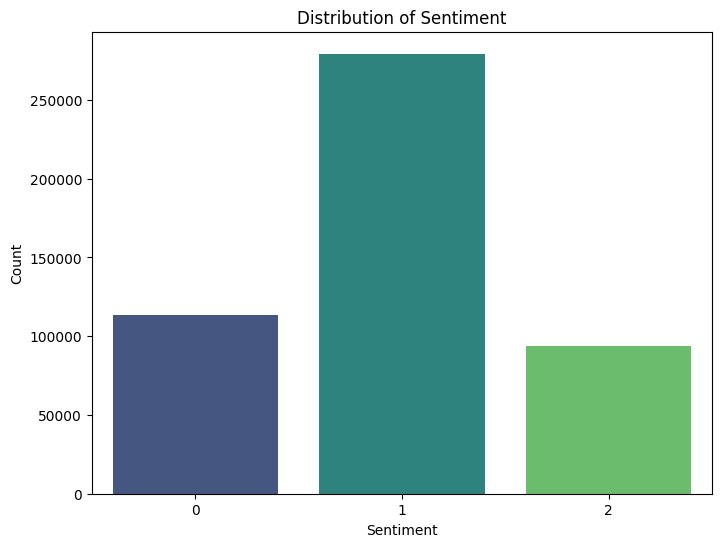

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count the occurrences of each sentiment class
sentiment_counts = match_data_pred['label'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [241]:
# Check if 'label' value is 1 and update accordingly
mask = (match_data_pred['label'] == 1)
match_data_pred.loc[mask, 'label'] = np.where(
    match_data_pred.loc[mask, 'negative'] > match_data_pred.loc[mask, 'positive'], 0, 2
)


match_data_pred['label'] = match_data_pred['label'].replace(2, 1)
match_data_pred = match_data_pred.drop(
    ['Title', 'processed_text','negative', 'neutral', 'positive'], axis=1)

match_data_pred.head(3)


,NewsID,NewsContent,Explicit_Company,pred_class,label
0,1,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,建设银行,0,0
1,2,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,农业银行,2,1
2,3,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"外运发展,中国国航",1,1


In [129]:
match_data_pred.to_excel('Task1.xlsx', index=False)

### 2.3 Second attempt of sentiment analysis with BERT using sentence as input 

In [132]:
with open("A_share_list.json", "r", encoding="utf-8") as file:
    a_share_list = json.load(file)

In [133]:
import pandas as pd

# Assuming you have your a_share_list and def_data already defined

def extract_sentence_after_match(news_text, a_share_companies):
    sentences = news_text.split('。')
    matched_sentences = []
    for sentence in sentences:
        for company in a_share_companies:
            if company["name"] in sentence or company["fullname"] in sentence or company["code"] in sentence:
                matched_sentences.append(sentence)
                break  # Break once a match is found for a company in the current sentence
    return '。'.join(matched_sentences)

# Add a new column 'Matched_Sentence' to store the matched sentence
def_match_data['Matched_Sentence'] = def_match_data.apply(lambda row: extract_sentence_after_match(str(row['NewsContent']), a_share_list), axis=1)
def_match_data['Matched_Sentence'] = def_match_data['Matched_Sentence'].apply(preprocess_text)
# checkpoint
def_match_data.to_csv('others/checkpoints/def_match_sentences.csv', index=False)


In [ ]:
import torch
from tqdm import tqdm
import numpy as np

# Move the model to GPU
model.to('cuda')

# Disable gradient calculation during inference
torch.set_grad_enabled(False)


# Initialize an empty list to store predicted classes
predicted_classes = []

# Function to get predicted class for a given text
def get_predicted_class_batch(texts):
    # Tokenize the texts
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)

    # Move input tensors to GPU
    inputs = {key: value.to('cuda') for key, value in inputs.items()}

    # Perform forward pass through the BERT model
    outputs = model(**inputs)

    # Get the predicted probabilities for each class (negative and positive)
    logits = outputs.logits
    probs = logits.softmax(dim=1)

    # Get the predicted sentiment classes (0 for negative, 1 for positive)
    predicted_classes_batch = torch.argmax(probs, dim=1).tolist()

    # Append the predicted classes to the list
    predicted_classes.extend(probs)

    return predicted_classes_batch

# Batch processing size
batch_size = 80

# Apply the function to the 'processed_text' column with tqdm for a progress bar
tqdm.pandas()
def_match_data['pred_class'] = def_match_data['Matched_Sentence'].progress_apply(
    lambda x: get_predicted_class_batch(x)[0]  # Extract the result from the list
)
def_match_data.to_csv('others/checkpoints/match_data_pred.csv', index=False)


### 2.4 second dataset cleanup

In [223]:
match_data2 = pd.read_csv('others/checkpoints/match_sentence_pred.csv')
match_data2.head(5)
print(match_data2.shape)

# Remove rows with NaN values
match_data2 = match_data2.dropna(subset=['Matched_Sentence'])

# Display the DataFrame after removing NaN values
print("\nDataFrame after removing NaN values:")
print(match_data2.shape)

(473685, 6)

DataFrame after removing NaN values:
(473685, 6)


In [224]:
pred_class2 = pd.read_csv('others/checkpoints/predicted_class2.csv', 
                         header = None, index_col=None)

csv_data2 = pred_class2.copy()
csv_data2 = csv_data2.drop(csv_data2.columns[3], axis=1)

# Replace "tensor([" with an empty string in the pred_class DataFrame
csv_data2[0] = csv_data2[0].replace(r'tensor\(\[|\s|\]|\,', '', regex=True)
csv_data2[1] = csv_data2[1].replace(r'tensor\(\[|\s|\]|\,', '', regex=True)
csv_data2[2] = csv_data2[2].replace(r'tensor\(\[|\s|\]|\,', '', regex=True)
csv_data2.rename(columns={0: 'negative', 1: 'neutral', 2: 'positive'}, inplace=True)

csv_data2 = csv_data2.apply(pd.to_numeric, errors='coerce')
csv_data2 = csv_data2.astype('float32')

# Display the modified DataFrame
print(csv_data2)

match_data_pred2 = pd.concat([match_data2, csv_data2], axis=1)

        negative   neutral  positive
0       0.998840  0.001081  0.000075
1       0.000039  0.999450  0.000514
2       0.000296  0.998010  0.001693
3       0.000053  0.999420  0.000530
4       0.002300  0.046500  0.951200
...          ...       ...       ...
473680  0.000048  0.999720  0.000231
473681  0.000118  0.019885  0.980000
473682  0.000078  0.000622  0.999300
473683  0.000042  0.999730  0.000232
473684  0.000048  0.999860  0.000092

[473685 rows x 3 columns]


In [225]:
match_data_pred2

,NewsID,Title,NewsContent,Explicit_Company,Matched_Sentence,pred_class,negative,neutral,positive
0,1,建设银行原董事长张恩照一审被判15年,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,建设银行,本报记者 田雨 李 京华 中国建设银行 股份 有限公司 原 董事长 张恩照 受贿案 ３ 日 ...,0,0.998840,0.001081,0.000075
1,2,农行信用卡中心搬到上海滩,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,农业银行,中国农业银行 信用卡 中心 由 北京 搬 到 上海 农行 行长 杨明 生日 前 在 信用卡 ...,1,0.000039,0.999450,0.000514
2,3,外运发展：价值型蓝筹股补涨要求强烈,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"外运发展,中国国航",在 新 基金 快速 发行 以及 申购 资金 回流 情况 下 市场 总体 上 呈现 资金 流动...,1,0.000296,0.998010,0.001693
3,4,胜利股份：稳步走强形成标准上升通道,胜利股份（000407）公司子公司填海造地2800亩，以青岛的地价估算，静态价值在10亿...,胜利股份,胜利 股份 47 公司 子公司 填海造地 亩 以 青岛 地价 估算 静态 价值 在 1 亿元 左右,1,0.000053,0.999420,0.000530
4,8,"南风化工：钾肥三雄之一 被""中化""相中",由于全球最大的俄罗斯Uralkaly钾矿被淹，产量大减，同时满洲里口岸铁路在修复线，导致...,冠农股份,由于 全球 最大 俄罗斯 Urlkly 钾矿 被淹 产量 大减 同时 满洲里 口岸 铁路 在...,2,0.002300,0.046500,0.951200
...,...,...,...,...,...,...,...,...,...
473680,1037031,亿华通：公司电解槽相关产品目前还处于产品的研发及测试阶段 尚未实现批量销售,每经AI快讯，有投资者在投资者互动平台提问：请问公司目前有没有电解槽产能，规划情况能否详细介...,亿华通,每经 AI 快讯 有 投资者 在 投资者 互动 平台 提问 请问 公司 目前 有没有 电解槽...,1,0.000048,0.999720,0.000231
473681,1037032,依米康：接受中泰证券调研,依米康（SZ 300249，收盘价：10.38元）发布公告称，2023年10月12日，依米康...,"中泰证券,依米康",依米康 SZ49 收盘价 1 元 发布公告 称年 1 月 1 日 依米康 接受 中 泰 证券...,2,0.000118,0.019885,0.980000
473682,1037033,天风证券给予中核科技买入评级 核电行业景气上行 公司有望乘风而起,天风证券10月13日发布研报称，给予中核科技（000777.SZ，最新价：13.03元）买入...,"中核科技,天风证券",天风 证券 1 月 1 日 发布 研 报称 给予 中核 科技 777SZ 最新 价 1 元 ...,2,0.000078,0.000622,0.999300
473683,1037034,海特生物：公司在抗癌药CPT获批后 会考虑适时开展CPT在海外的临床并谋求上市,有投资者提问：抗癌药CPT获批后，公司是否应该按照股权协议继续收购沙东股权，适应症为MM的C...,海特生物,有 投资者 提问 抗癌药 CPT 获批 后 公司 应该 按照 股权 协议 继续 收购 沙东 ...,1,0.000042,0.999730,0.000232


C:\Users\cindy\AppData\Local\Temp\ipykernel_26216\1082252806.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts2.index, y=sentiment_counts.values, palette="viridis")


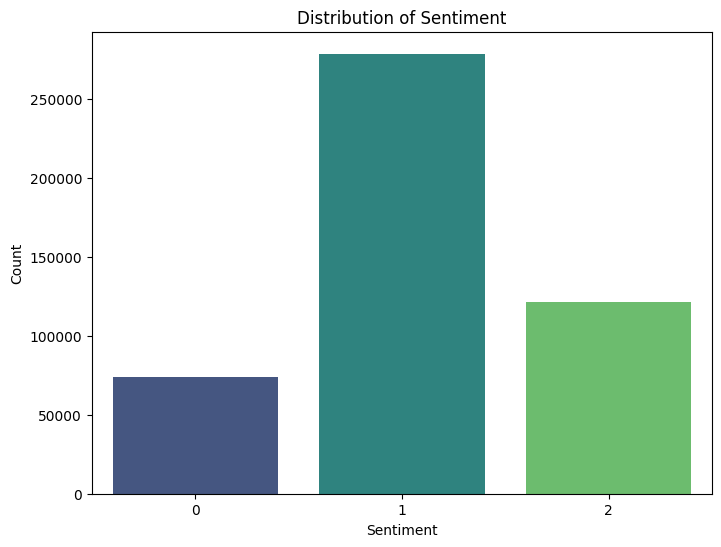

In [226]:
match_data_pred2['label'] = np.argmax(match_data_pred2[['negative', 'neutral', 'positive']].values, axis=1)
#match_data_pred.to_csv('others/checkpoints/match_merged_class.csv', index=False)

import matplotlib.pyplot as plt
import seaborn as sns
# Count the occurrences of each sentiment class
sentiment_counts2 = match_data_pred2['label'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts2.index, y=sentiment_counts.values, palette="viridis")
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [227]:
# Check if 'label' value is 1 and update accordingly
mask2 = (match_data_pred2['label'] == 1)
match_data_pred2.loc[mask2, 'label'] = np.where(
    match_data_pred2.loc[mask2, 'negative'] > match_data_pred2.loc[mask2, 'positive'], 0, 2
)


match_data_pred2['label'] = match_data_pred2['label'].replace(2, 1)
match_data_pred2 = match_data_pred2.drop(
    ['Title', 'Matched_Sentence','negative', 'neutral', 'positive', 'pred_class'], axis=1)

match_data_pred2.head(3)


,NewsID,NewsContent,Explicit_Company,label
0,1,本报记者 田雨 李京华 中国建设银行股份有限公司原董事长张恩照受贿案３日一审宣...,建设银行,0
1,2,中国农业银行信用卡中心由北京搬到上海了！ 农行行长杨明生日前在信用卡中心揭牌仪式上...,农业银行,1
2,3,在新基金快速发行以及申购资金回流的情况下，市场总体上呈现资金流动性过剩格局，考虑到现阶段...,"外运发展,中国国航",1


In [294]:
match_data_pred2.to_excel('Task1.xlsx', index=False)

### 2.5 discussion of processing whole text vs relevant sentence 

In [249]:
import pandas as pd

# Assuming df1 and df2 are your two DataFrames
# Merge the DataFrames on 'NewsID'
merged_df = pd.merge(match_data_pred, match_data_pred2, on='NewsID', suffixes=('_df1', '_df2'))
merged_df = merged_df.drop(['Explicit_Company_df2', 'NewsContent_df2'], axis=1)

# Filter rows where labels do not match
mismatched_rows = merged_df[merged_df['label_df1'] != merged_df['label_df2']]

# Display the mismatched rows
print("no. of Mismatched Rows:")
print(len(mismatched_rows))


no. of Mismatched Rows:
81175


In [293]:
index = 987
print(mismatched_rows.iloc[index, 1])
print('corresponding company:', mismatched_rows.iloc[index,2])
print('with paragraph input for BERT:',mismatched_rows.iloc[index,4])
print('with sentence input for BERT:',mismatched_rows.iloc[index,5])


本报讯 航天机电(600151)今日公告，公司与四川新光硅业高科技有限责任公司(下称：新光硅业)主要股东就新光硅业增资扩股事项因谈判无进展，公司决定放弃入驻新光硅业。另，经股东大会批准，公司已通过全资子公司上海神舟新能源发展有限公司与上海航天工业总公司合资成立了内蒙古神舟硅业有限责任公司。
corresponding company: 航天机电
with paragraph input for BERT: 1
with sentence input for BERT: 0


In [272]:
mismatched_rows

,NewsID,NewsContent_df1,Explicit_Company_df1,pred_class,label_df1,label_df2
7,12,大盘运行 深沪两市成交金额相加达到713亿元，成为8月份以来的最大成交量，也是5月...,"大秦铁路,武钢股份,特力A,中信证券,航天机电,鞍钢股份,祁连山,天山股份,柳工,保利地产,...",1,1,0
18,45,周玉成曾告诉本报记者：“华源集团的徽标中融合了产业资本、金融资本和外贸资本的内涵。” ...,交通银行,0,0,1
19,46,明年中国经济的宏观调控是否应该放松？专家学者们出现了分歧。昨日，国家发改委宏观经济研究院的经...,光大证券,0,0,1
21,50,本报记者 徐国杰 上海报道 统计数据显示，1400余家披露2006年第三季...,晋西车轴,1,0,1
40,99,本报记者 王磊 经过昨日的单边上扬后，沪综指直接来到了2100点，盘中摸...,"万科A,柳工,浦发银行,太钢不锈,北辰实业",1,0,1
...,...,...,...,...,...,...
473655,1037000,上证报中国证券网讯（记者黄坤）10月12日至13日，2023上海全球资产管理论坛在上海举行。...,交通银行,1,1,0
473656,1037004,10月13日，两市股指盘中弱势震荡下探，沪指再次失守3100点，创业板指跌逾1%跌破2000...,中国银行,0,0,1
473657,1037005,10月13日，沪深两市全天成交额8084亿元，较上一交易日缩窄229亿元。个股方面，赛力斯成...,"欧菲光,润和软件,张江高科",0,0,1
473658,1037006,上证报中国证券网讯（记者费天元）10月13日，A股市场全天弱势盘整。上证指数收盘报3088....,众生药业,0,0,1
